In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import math
import copy
from IPython.display import display
pd.options.mode.chained_assignment = None

In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt


In [3]:
path_to_file = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(path_to_file+'main_task.csv')
df_test = pd.read_csv(path_to_file+'kaggle_task.csv')
pd.set_option('display.max_columns', 200)
display(df_train.head(2))
display(df_test.head(2))

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944


In [4]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Sample'] = 1 # помечаем где у нас трейн
df_test['Sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [5]:
data.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,Sample,Rating
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0


### Блок функций

In [6]:
# Функция для подсчета пустых значений
def missing_values_table(df):
        # Количество пропущенных значений
        mis_val = df.isnull().sum()
        
        # Процент пропущенных значений
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        #Таблица с результатами
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Переименовываем колонки
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Сортируем значения по проценту
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Печать дополнительной информации
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
       
        return mis_val_table_ren_columns
    
 # функция для обработки Cuisine Style
def list_unrar(list_of_lists):
    result=[]
    for lst in list_of_lists:
        result.extend(lst)
    return result

# функции для поиска самого свежего отзыва
def time_to_now(row):
    if row['date_of_Review'] == []:
        return None
    return datetime.datetime.now() - pd.to_datetime(row['date_of_Review']).max()

def time_between_Reviews(row):
    if row['date_of_Review'] == []:
        return None
    return pd.to_datetime(row['date_of_Review']).max() - pd.to_datetime(row['date_of_Review']).min()

# функция для стандартизации
def StandardScaler_column(d_col):
    scaler = StandardScaler()
    scaler.fit(data[[d_col]])
    return scaler.transform(data[[d_col]])

In [7]:
missing_values_table(data)

Your selected dataframe has 11 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values
Price Range,17361,34.7
Cuisine Style,11590,23.2
Number of Reviews,3200,6.4
Reviews,2,0.0


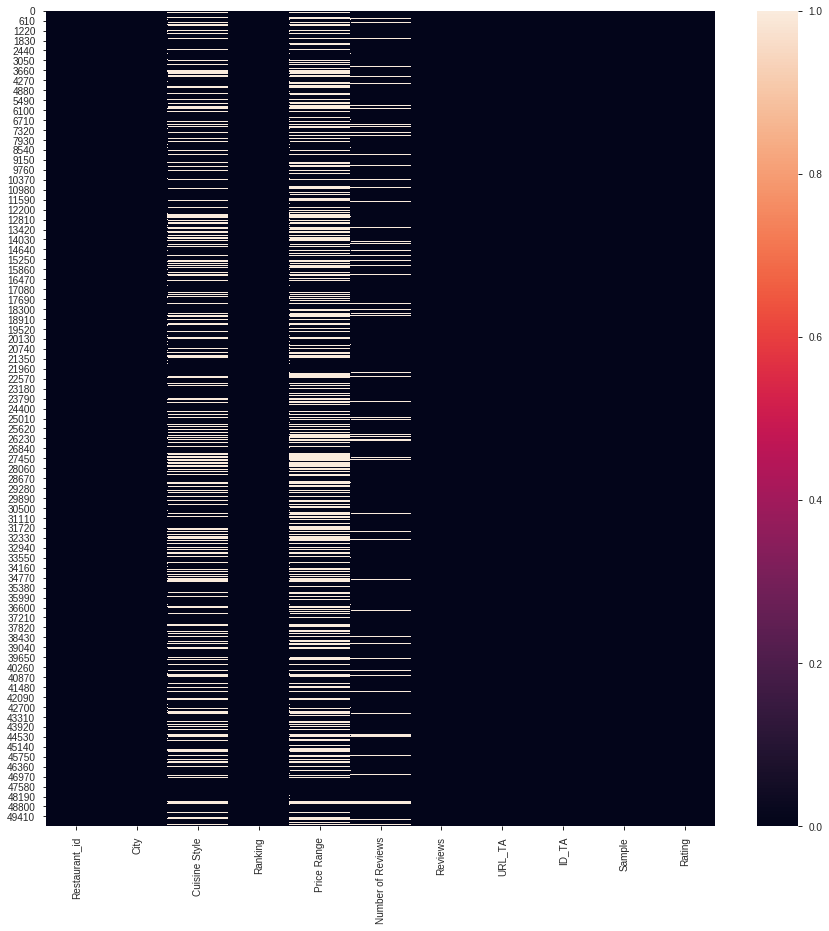

In [8]:
plt.subplots(figsize=(15, 15))
sns.heatmap(data.isnull())

In [9]:
data['code_Restaurant_id'] = data['Restaurant_id'].apply(lambda x: float(x[3:]))

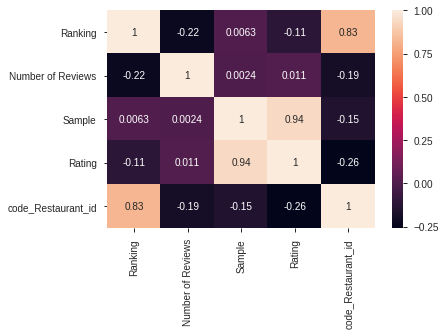

In [10]:
sns.heatmap(data.corr(),annot=True)

In [11]:
data.drop(['code_Restaurant_id'], axis=1, inplace=True)

### Cuisine Style

In [12]:
# в переменной 9283 (23.2%) пропущенных значений 
# сохраним эту информацию
data['NAN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('float64') 

# заполним пропуски значением 'Other'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

In [13]:
# проведем обработку значений переменной
data['Cuisine Style'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'") 
temp_list = data['Cuisine Style'].tolist()
temp_counter=Counter(list_unrar(temp_list))

In [14]:
# сформируем список достаточно уникальных кухонь и сформируем на его основе новый признак
list_of_unique_Cuisine = [x[0] for x in temp_counter.most_common()[-16:]]
data['unique_Cuisine_Style'] = data['Cuisine Style'].apply(lambda x: 1 if len(set(x) & set(list_of_unique_Cuisine))>0  else 0).astype('float64')

In [15]:
for cuisine in temp_counter:
    data[cuisine] = data['Cuisine Style'].apply(lambda x: 1 if cuisine in x else 0 ).astype('float64')

# генерируем новый признак кол-во кухонь в ресторане
data['count_Cuisine_Style'] = data['Cuisine Style'].apply(lambda x: len(x)).astype('float64')

### Price Range

In [16]:
# в переменной очень много пропусков 13886 (34.7%)
# сохраним информацию о пропусках чтобы не потерять
data['NaN_Price Range'] = pd.isna(data['Price Range']).astype('float64') 

# заполним значения в переменной по словарю
dic_value_Price = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price_Range']=data['Price Range'].map(lambda x: dic_value_Price.get(x,x))

# 18412 ресторанов это более 70% из заполненной информации имеют средний параметр цены
# поэтому заполняем пропуски двойкой (2)
data['Price_Range'] = data['Price_Range'].fillna(2)

### Number of Reviews

In [17]:
# в переменной 2543 (6.4%) пропущенных значений 
# сохраним эту информацию
data['NAN_Number of Reviews'] = pd.isna(data['Number of Reviews']).astype('float64')

# для удобства изменим название столбца
data.rename(columns={'Number of Reviews': 'Number_of_Reviews'}, inplace=True)

### Reviews

In [18]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')
data['empty_Reviews'] = (data['Reviews']=='[[], []]').astype('float64')

In [19]:
data['date_of_Review'] = data['Reviews'].str.findall('\d+/\d+/\d+')
data['len_date'] = data['date_of_Review'].apply(lambda x: len(x))

In [20]:
print("кол-во значений Reviews с тремя датами :=" , len(data[data['len_date']==3]))
print("значения Reviews с тремя датами :=")
temp_list = data[data['len_date']==3].Reviews.to_list()
display(data[data['len_date']==3].Reviews.to_list())
print("даты после обработки регулярными выражениями:")
display([re.findall('\d+/\d+/\d+', x) for x in temp_list])

кол-во значений Reviews с тремя датами := 4
значения Reviews с тремя датами :=


["[['We visited 21/10/17', 'Best Kebab in London'], ['12/22/2017', '10/19/2017']]",
 "[['Good Museum Cafeteria', 'Lunch 30/5/2017'], ['04/13/2017', '05/30/2017']]",
 "[['The desserts arcade !', 'Visit today 3/1/2017'], ['06/02/2017', '01/03/2017']]",
 "[['lunch 29/9/2016', 'Unplanned Great Dinner'], ['09/30/2016', '08/25/2016']]"]

даты после обработки регулярными выражениями:


[['21/10/17', '12/22/2017', '10/19/2017'],
 ['30/5/2017', '04/13/2017', '05/30/2017'],
 ['3/1/2017', '06/02/2017', '01/03/2017'],
 ['29/9/2016', '09/30/2016', '08/25/2016']]

In [21]:
data['len_date'].date_of_Review = data[data['len_date']==3].date_of_Review.apply(lambda x: x.pop(0))

In [22]:
print("кол-во значений Reviews с одной датой :=" , len(data[data['len_date']==1]))
display(data[data['len_date']==1].Reviews[:4])

кол-во значений Reviews с одной датой := 5680


12    [['You always feel very Welcome at this cozy.....
31                 [['Very good food'], ['09/24/2017']]
48                         [['Thomas'], ['01/06/2016']]
50    [['The best in Budapest so far'], ['03/05/2017']]
Name: Reviews, dtype: object

In [23]:
data['one_Review'] = (data['len_date']==1).astype('float64')

# заполним перерыв между отзывами (по отзывам где len = 2) и насколько давно был сделан последний самый свежий отзыв
# используем для этого функции созданные ранее:
data['day_to_now'] = data.apply(time_to_now, axis = 1).dt.days
data['day_between_Reviews'] = data[data['len_date']==2].apply(time_between_Reviews, axis = 1).dt.days

In [24]:
data['out_day_between_Reviews'] = (data['day_between_Reviews']==0).astype('float64')

# и удаляем выбросы
data.loc[data['day_between_Reviews']==0, 'day_between_Reviews'] = None

In [25]:
data['day_to_now'].isna().sum()

8114

In [26]:
data['day_between_Reviews'].isna().sum()

14429

In [27]:
data['code_ID_TA'] = data['ID_TA'].apply(lambda x: float(x[1:]))

In [28]:
data['code_after_g_URL_TA'] = data['URL_TA'].str.split('-').apply(lambda x: x[1][1:]).astype('float64')

###  Создадим dummy переменные по городам

In [29]:
City_dummies = pd.get_dummies(data['City'], dummy_na=False).astype('float64')
data = pd.concat([data,City_dummies], axis=1)

In [30]:
le = LabelEncoder()
le.fit(data['City'])
data['code_City'] = le.transform(data['City'])

In [31]:
NotCapitalCity = ['Barcelona', 'Milan', 'Hamburg', 'Munich', 
                          'Lyon', 'Zurich', 'Oporto', 'Geneva', 'Krakow']
data['Capital_City'] = data['City'].apply(lambda x: 0.0 if x in NotCapitalCity else 1.0)

In [32]:
countries = {'London' : 'England', 'Paris' : 'France', 'Madrid' : 'Spain', 
                  'Barcelona' : 'Spain', 'Berlin' : 'Germany', 'Milan' : 'Italy', 
                  'Rome' : 'Italy', 'Prague' : 'Czech_c', 'Lisbon' : 'Portugal', 
                  'Vienna' : 'Austria', 'Amsterdam' : 'Holland', 
                  'Brussels' : 'Belgium', 'Hamburg' : 'Germany', 'Munich' : 'Germany', 
                  'Lyon' : 'France', 'Stockholm' : 'Sweden', 'Budapest' : 'Romania', 
                  'Warsaw' : 'Poland', 'Dublin' : 'Ireland', 'Copenhagen' : 'Denmark', 
                  'Athens' : 'Greece', 'Edinburgh' : 'Scotland', 'Zurich' : 'Switzerland', 
                  'Oporto' : 'Portugal', 'Geneva' : 'Switzerland', 'Krakow' : 'Poland', 
                  'Oslo' : 'Norway', 'Helsinki' : 'Finland', 'Bratislava' : 'Slovakia', 
                  'Luxembourg' : 'Luxembourg_c', 'Ljubljana' : 'Slovenia'}
data['Сountry'] = data.apply(lambda row: countries[row['City']], axis = 1)

le = LabelEncoder()
le.fit(data['Сountry'])
data['code_Сountry'] = le.transform(data['Сountry'])

In [33]:
city_population= {'London' : 8908, 'Paris' : 2206, 'Madrid' : 3223, 'Barcelona' : 1620, 
                        'Berlin' : 6010, 'Milan' : 1366, 'Rome' : 2872, 'Prague' : 1308, 
                        'Lisbon' : 506, 'Vienna' : 1888, 'Amsterdam' : 860, 'Brussels' : 179, 
                        'Hamburg' : 1841, 'Munich' : 1457, 'Lyon' : 506, 'Stockholm' : 961, 
                        'Budapest' : 1752, 'Warsaw' : 1764, 'Dublin' : 553, 
                        'Copenhagen' : 616, 'Athens' : 665, 'Edinburgh' : 513, 
                        'Zurich' : 415, 'Oporto' : 240, 'Geneva' : 201, 'Krakow' : 769, 
                        'Oslo' : 681, 'Helsinki' : 643, 'Bratislava' : 426, 
                        'Luxembourg' : 119, 'Ljubljana' : 284}
data['Сity_population'] = data.apply(lambda row: city_population[row['City']], axis = 1)

### Ranking

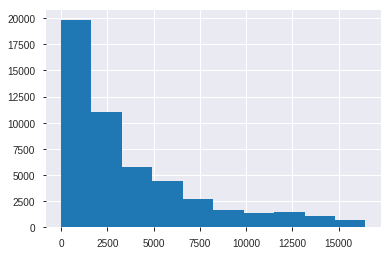

In [34]:
data.Ranking.hist()

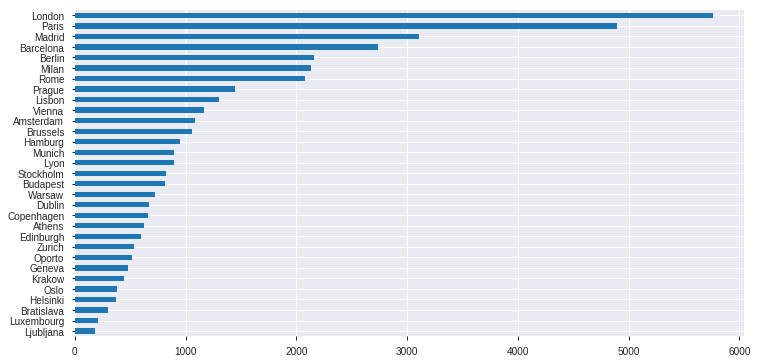

In [35]:
# У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?
plt.rcParams['figure.figsize'] = (12,6)
df_train['City'].value_counts(ascending=True).plot(kind='barh')

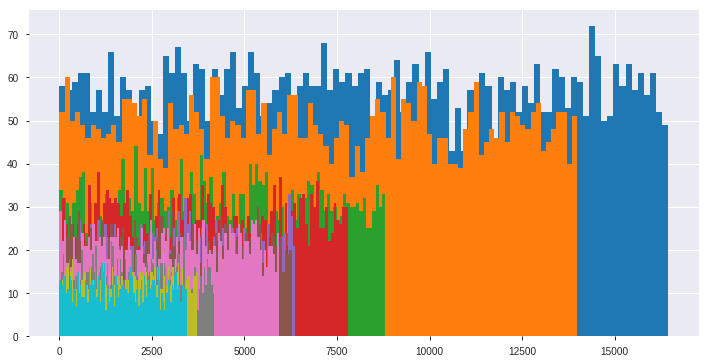

In [36]:
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [37]:
# нормализуем признаки
mean_Ranking= data.groupby(['City'])['Ranking'].mean()
count_Restorant_in_City = data['City'].value_counts(ascending=False)
data['mean_Ranking'] = data['City'].apply(lambda x: mean_Ranking[x])
data['count_Restorant_in_City'] = data['City'].apply(lambda x: count_Restorant_in_City[x])
data['norm_Ranking'] = (data['Ranking'] - data['mean_Ranking']) / data['count_Restorant_in_City']

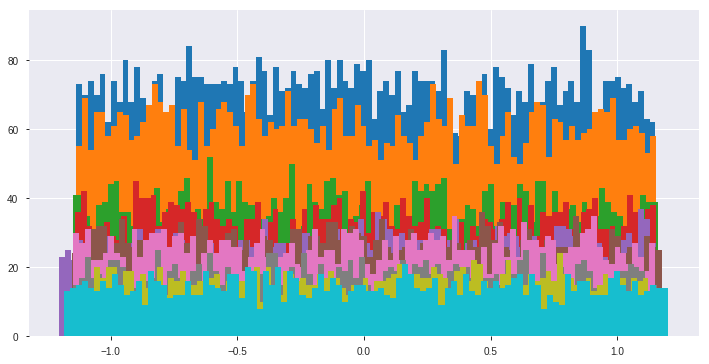

In [38]:
for x in (data['City'].value_counts())[0:10].index:
    data['norm_Ranking'][data['City'] == x].hist(bins=100)
plt.show()

In [39]:
data['norm_Population'] = data['Сity_population']/data['count_Restorant_in_City']

In [40]:
data.drop(['Restaurant_id','City', 'Cuisine Style', 'Price Range', 'Reviews', 'URL_TA', 'ID_TA', 'date_of_Review', 'len_date', 'Сountry', 'Сity_population', 'mean_Ranking', 'count_Restorant_in_City', ], axis=1, inplace=True, errors='ignore')

In [41]:
display(data.head())

,Ranking,Number_of_Reviews,Sample,Rating,NAN_Cuisine Style,unique_Cuisine_Style,Bar,Pub,European,Scandinavian,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Other,Greek,Czech,Eastern European,Central European,Pizza,British,Spanish,Norwegian,African,Moroccan,Middle Eastern,Halal,Indian,Thai,Dutch,Welsh,American,Steakhouse,Soups,Scottish,Fusion,Street Food,Hungarian,Asian,Wine Bar,Barbecue,Central American,Peruvian,South American,Irish,Polish,Vietnamese,Lebanese,Turkish,Healthy,Japanese,Sushi,Austrian,Chinese,Danish,International,Gastropub,Korean,German,Contemporary,Arabic,Diner,Swiss,Swedish,Persian,Australian,Grill,Mexican,Latin,Belgian,Argentinean,Tunisian,Russian,Nepali,Bangladeshi,Colombian,Sri Lankan,Pakistani,Brew Pub,Israeli,Brazilian,Delicatessen,Kosher,Ethiopian,Taiwanese,Indonesian,Malaysian,Venezuelan,Balti,Armenian,Slovenian,Caribbean,Jamaican,Ecuadorean,Chilean,Hawaiian,Minority Chinese,Croatian,Cambodian,Afghani,Tibetan,Romanian,Southwestern,Mongolian,Cajun & Creole,Singaporean,Filipino,Cuban,Native American,Canadian,Egyptian,Azerbaijani,Georgian,Yunnan,New Zealand,Ukrainian,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,count_Cuisine_Style,NaN_Price Range,Price_Range,NAN_Number of Reviews,empty_Reviews,one_Review,day_to_now,day_between_Reviews,out_day_between_Reviews,code_ID_TA,code_after_g_URL_TA,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_City,Capital_City,code_Сountry,norm_Ranking,norm_Population
0,12963.0,4.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,1.0,0.0,NaN,NaN,0.0,10746918.0,187147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24,1.0,6,0.986320,0.361166
1,106.0,97.0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,2.0,0.0,0.0,0.0,1229.0,37.0,0.0,6674944.0,189934.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,1.0,5,-0.964698,1.353684
2,810.0,28.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1206.0,22.0,0.0,13129638.0,186525.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,1.0,17,-0.100846,0.688591
3,1669.0,202.0,0,0.

In [42]:
# стандартизируем все столбцы кроме целевой и Sample
for i  in list(data.columns):
    if i not in ['Rating','Sample']:
        data[i] = StandardScaler_column(i)
        if len(data[data[i].isna()]) < len(data):
            data[i] = data[i].fillna(0)

In [43]:
display(data.describe().head(1))

,Ranking,Number_of_Reviews,Sample,Rating,NAN_Cuisine Style,unique_Cuisine_Style,Bar,Pub,European,Scandinavian,Gluten Free Options,Vegetarian Friendly,Vegan Options,Italian,Mediterranean,Seafood,French,Cafe,Fast Food,Portuguese,Other,Greek,Czech,Eastern European,Central European,Pizza,British,Spanish,Norwegian,African,Moroccan,Middle Eastern,Halal,Indian,Thai,Dutch,Welsh,American,Steakhouse,Soups,Scottish,Fusion,Street Food,Hungarian,Asian,Wine Bar,Barbecue,Central American,Peruvian,South American,Irish,Polish,Vietnamese,Lebanese,Turkish,Healthy,Japanese,Sushi,Austrian,Chinese,Danish,International,Gastropub,Korean,German,Contemporary,Arabic,Diner,Swiss,Swedish,Persian,Australian,Grill,Mexican,Latin,Belgian,Argentinean,Tunisian,Russian,Nepali,Bangladeshi,Colombian,Sri Lankan,Pakistani,Brew Pub,Israeli,Brazilian,Delicatessen,Kosher,Ethiopian,Taiwanese,Indonesian,Malaysian,Venezuelan,Balti,Armenian,Slovenian,Caribbean,Jamaican,Ecuadorean,Chilean,Hawaiian,Minority Chinese,Croatian,Cambodian,Afghani,Tibetan,Romanian,Southwestern,Mongolian,Cajun & Creole,Singaporean,Filipino,Cuban,Native American,Canadian,Egyptian,Azerbaijani,Georgian,Yunnan,New Zealand,Ukrainian,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian,count_Cuisine_Style,NaN_Price Range,Price_Range,NAN_Number of Reviews,empty_Reviews,one_Review,day_to_now,day_between_Reviews,out_day_between_Reviews,code_ID_TA,code_after_g_URL_TA,Amsterdam,Athens,Barcelona,Berlin,Bratislava,Brussels,Budapest,Copenhagen,Dublin,Edinburgh,Geneva,Hamburg,Helsinki,Krakow,Lisbon,Ljubljana,London,Luxembourg,Lyon,Madrid,Milan,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,code_City,Capital_City,code_Сountry,norm_Ranking,norm_Population
count,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0,50000.0


In [44]:
train_data = data.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data.query('Sample == 0').drop(['Sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [45]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [46]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 178), (40000, 178), (40000, 177), (32000, 177), (8000, 177))

In [47]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [48]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [49]:
# функция стандартного математического округления
def classic_round(d_num):
    return int(d_num + (0.5 if d_num > 0 else -0.5))

# функция округления кратно 0.5
def my_round(d_pred):
    result = classic_round(d_pred*2)/2
    if result <=5:
        return result
    else:
        return 5
    
# создание функции для векторов np
my_vec_round = np.vectorize(my_round)

In [50]:
y_pred = my_vec_round(y_pred)

In [51]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

MAE: 0.1644375


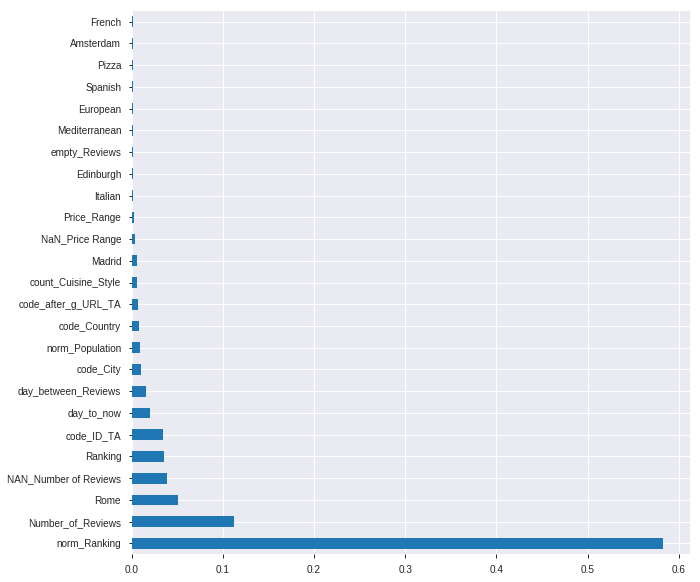

In [52]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [53]:
train_data = data.query('Sample == 1').drop(['Sample'], axis=1)
test_data = data.query('Sample == 0').drop(['Sample','Rating'], axis=1)
y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

In [54]:
sample_submission = pd.read_csv(path_to_file+'sample_submission.csv')
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [55]:
sample_submission.shape, test_data.shape, X.shape, y.shape

((10000, 2), (10000, 177), (40000, 177), (40000,))

In [56]:
model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.6s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=42, verbose=1,
                      warm_start=False)

In [57]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [58]:
predict_submission=my_vec_round(predict_submission)
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4. , 4. ])

In [59]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,1.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


In [60]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head()

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
